Лабораторная работа №4. Построение нейросетевого регрессора.
Цель работы – написать программу на языках Python, выполняющую построение и обучение нейронных сетей прямого распространения, решающих задачу регрессии (выборки получены от преподавателя), требуется подобрать безизбыточную архитектуру сети, работающей с допустимым уровнем ошибки и визуализировать процесс обучения моделей. Результаты работы привести в отчете.

Построение нейросетевого регрессора по вариантам:

Построение нейросетевого регрессора. Написать программу на Python, которая обучает нейросетевой регрессор, с помощью библиотек scikit-learn и keras. Датасет – Лесные пожары (https://archive.ics.uci.edu//ml/datasets/Forest+Fires), предсказываемое значение – площадь пожара (Area);

In [55]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

1. Импорт необходимых библиотек
numpy и pandas: для работы с данными и их манипуляции.
matplotlib.pyplot: для визуализации графиков, таких как потери и точность обучения.
keras: для создания и обучения нейронных сетей.
sklearn: для разделения данных на обучающую и тестовую выборку, а также для расчета метрик классификации, таких как точность, AUC и построение матрицы ошибок.

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

2. Загрузка данных
Загрузим данные о лесных пожарах из https://archive.ics.uci.edu/dataset/162/forest+fires.

In [57]:
# Загрузка данных из CSV файла
file_path = "/kaggle/input/forest-fires/forestfires.csv"  # Путь к файлу
data = pd.read_csv(file_path)  # Чтение данных
print(data.head()) 
print(data.columns)

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0
Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')


Преобразование категориальных переменных в числовые

In [58]:
columns = data.columns
# Преобразование категориальных признаков в числовые
label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()  # Создание объекта LabelEncoder для каждой колонки
    data[column] = label_encoders[column].fit_transform(data[column])  # Преобразование категориальных значений в числовые
    
print(data.head())

   X  Y  month  day  FFMC  DMC   DC  ISI  temp  RH  wind  rain  area
0  6  3      7    0    28   37   41   29    12  34    14     0     0
1  6  2     10    5    56   49  144   42    85  16     1     0     0
2  6  2     10    2    56   56  156   42    55  16     2     0     0
3  7  4      7    0    67   48   33   64    13  72     8     1     0
4  7  4      7    3    46   66   46   68    30  73     3     0     0


3. Анализ данных
Проверим наличие пропущенных значений и выведем общую информацию о наборе данных

In [59]:
# Проверка на пропущенные значения и описание набора данных
print(data.info())
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X       517 non-null    int64
 1   Y       517 non-null    int64
 2   month   517 non-null    int64
 3   day     517 non-null    int64
 4   FFMC    517 non-null    int64
 5   DMC     517 non-null    int64
 6   DC      517 non-null    int64
 7   ISI     517 non-null    int64
 8   temp    517 non-null    int64
 9   RH      517 non-null    int64
 10  wind    517 non-null    int64
 11  rain    517 non-null    int64
 12  area    517 non-null    int64
dtypes: int64(13)
memory usage: 52.6 KB
None
                X           Y       month         day        FFMC         DMC  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     3.669246    2.286267    5.758221    2.736944   63.599613  120.056093   
std      2.313778    1.184225    4.373275    1.925061   23.103161   56.299197   
m

4. Визуализация корреляций
Выведем матрицу корреляций между признаками для лучшего понимания взаимосвязей в данных.

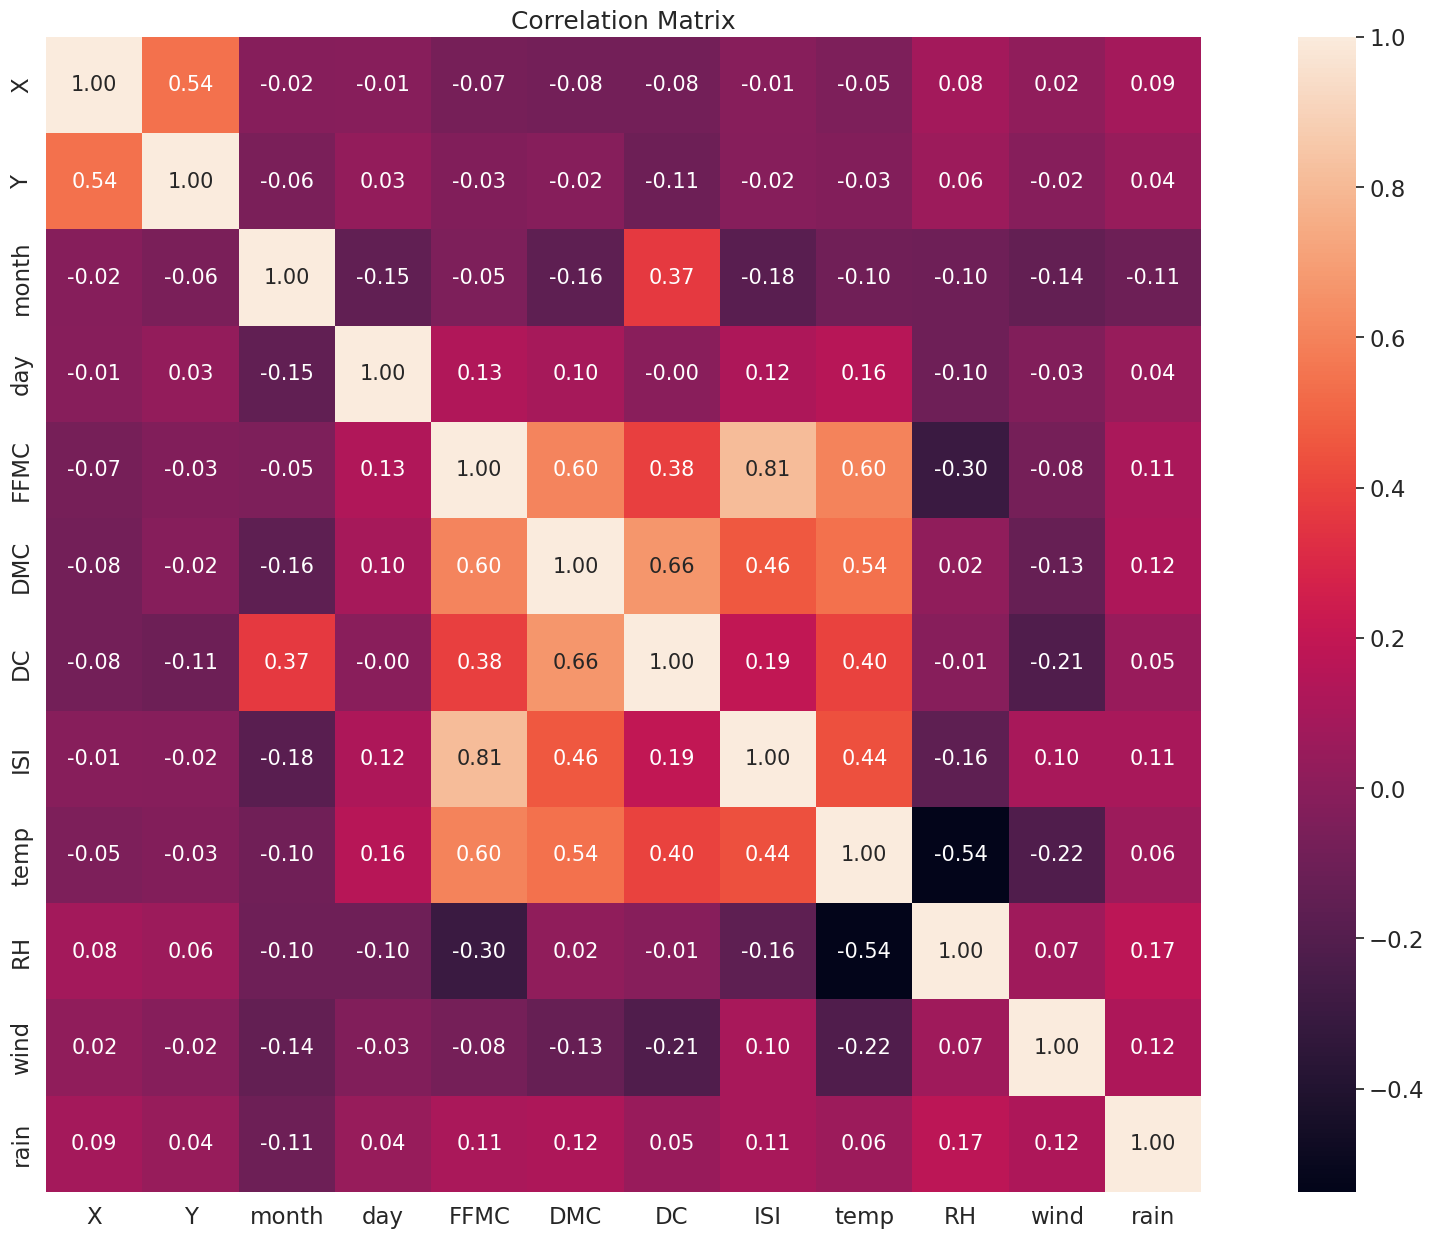

In [60]:
# Вывод матрицы корреляций признаков
cols = data.drop('area', axis=1).columns  # Удаление целевой переменной, выбор признаков
cm = np.corrcoef(data[cols].values.T)  # Вычисление корреляционной матрицы
sns.set(font_scale=1.5)  # Установка масштаба шрифта
fig, ax = plt.subplots(figsize=(25, 15))  # Создание графика с заданными размерами
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},  # Построение тепловой карты
                 yticklabels=cols, xticklabels=cols)  # Настройка подписей осей
plt.title("Correlation Matrix")  # Заголовок графика
plt.show()  # Отображение графика



5. Подготовка данных
Разделим данные на обучающую и тестовую выборки, а затем стандартизируем признаки для улучшения обучения модели.

In [61]:
# Разделение данных на обучающую и тестовую выборки
X = data.drop('area', axis=1)  # Признаки
y = data['area']  # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


6. Создание модели нейронной сети
Определим архитектуру полносвязной нейронной сети и скомпилируем модель.

In [62]:
# Создание модели полносвязной нейронной сети
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # Входной слой с 128 нейронами и функцией активации ReLU
model.add(Dense(256, activation='relu'))  # Добавление скрытого слоя с 256 нейронами и функцией активации ReLU
model.add(Dense(1, activation='linear'))  # Выходной слой с одним нейроном для предсказания площади (регрессия)

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])  # Определение функции потерь MSE, оптимизатора Adam, метрик MAE и MSE



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7. Обучение модели
Обучим модель, используя 50 эпох, и выделим 20% данных для валидации.

In [63]:
# Обучение модели
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 10890.0225 - mae: 65.8982 - mse: 10890.0225 - val_loss: 8615.1719 - val_mae: 57.2980 - val_mse: 8615.1719
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9543.1260 - mae: 58.6310 - mse: 9543.1260 - val_loss: 8274.1973 - val_mae: 57.2725 - val_mse: 8274.1973
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10880.0068 - mae: 68.4063 - mse: 10880.0068 - val_loss: 7782.9819 - val_mae: 57.2038 - val_mse: 7782.9819
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8940.1309 - mae: 62.9317 - mse: 8940.1309 - val_loss: 7183.7515 - val_mae: 57.1747 - val_mse: 7183.7515
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7649.2803 - mae: 60.4779 - mse: 7649.2803 - val_loss: 6503.0708 - val_mae: 57.5505 - val_mse: 6503.0708
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7533.9956 - mae: 64.3398 - mse: 7533.9956 - val_loss: 5936.1914 - val_mae: 58.5418 - val_mse: 5936.1914
Epoch 7/50
11/11 ━━━━━━

8. Визуализация результатов
Построим график потерь на обучающей и валидационной выборках для оценки работы модели.

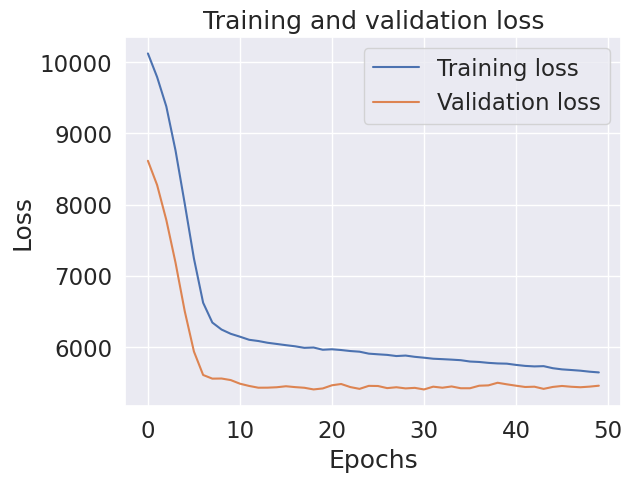

In [64]:
# Построение графика потерь
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

9. Оценка модели
После обучения модели вычислим и выведем метрики оценки качества модели: среднюю квадратичную ошибку (MSE), среднюю абсолютную ошибку (MAE) и коэффициент детерминации (R²).

In [65]:
# Оценка модели
predictions = model.predict(X_test)  # Предсказания
mse = mean_squared_error(y_test, predictions)  # Среднеквадратичная ошибка
mae = mean_absolute_error(y_test, predictions)  # Средняя абсолютная ошибка
r2 = r2_score(y_test, predictions)  # Коэффициент детерминации

# Вывод результатов
print('Mean squared error from neural network:', mse)
print('Mean absolute error from neural network:', mae)
print('R2 score from neural network:', r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean squared error from neural network: 7331.688741244613
Mean absolute error from neural network: 72.18305681301997
R2 score from neural network: -0.018320348458401803
